# P5.5  Construcción Estimador de Turbidez

In [ ]:
import pandas as pd
import math
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

path='turbitidy_cycle17_21.csv'


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Definición de Métricas utilizadas

In [ ]:
def calculate_error(y_pred,y_test, print_message=True):
#Imprime los resultados del 
#y_pred: tipo 1D array o asimilado, valores prededecidos
#y_test: tipo 1D array o asimilado, valores reaales
#print_message :imprime los errores calculado por pantalla.


  # # Mean Absolute Error (MAE)
  MAE = np.mean(abs(y_pred - y_test))
  
  # Median Absolute Error (MedAE)
  MEDAE = np.median(abs(y_pred - y_test))


  # Mean Squared Error (MSE)
  MSE = np.square(np.subtract(y_pred, y_test)).mean()
 

  # Root Mean Squarred Error (RMSE) 
  RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
  

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100

  # Symmetric Median Absolute Percentage Error (MDAPE) 
  SMAPE = 100/len(y_test) * np.sum(2 * np.abs(y_pred -y_test) / (np.abs(y_test) + np.abs(y_pred)))

  if (print_message) :
      print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))
      print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))
      print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))
      print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))
      print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')
      print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')
      print('Symmetric Median Absolute Percentage Error (SMAPE): ' + str(np.round(SMAPE, 2)) + ' %')

  return MAE,MEDAE,MSE,RMSE,MAPE,MDAPE,SMAPE

In [ ]:
df_turbidity_source = pd.read_csv(path, delimiter=',',infer_datetime_format=True, index_col='datetime',parse_dates=True)
df_turbidity_source['116507_63680']=pd.to_numeric(df_turbidity_source['116507_63680'])


In [ ]:
df_turbidity= df_turbidity_source.copy()

Comprobar siempre cómo han sido interpretados los campos, especialmente los numéricos y las fechas, que no aparezcan como tipos cadena.

In [ ]:
df_turbidity_source.dtypes

agency_cd           object
site_no              int64
tz_cd               object
116507_63680       float64
116507_63680_cd     object
dtype: object

Comprobación de Indices: 

Mostramos el Gráfico

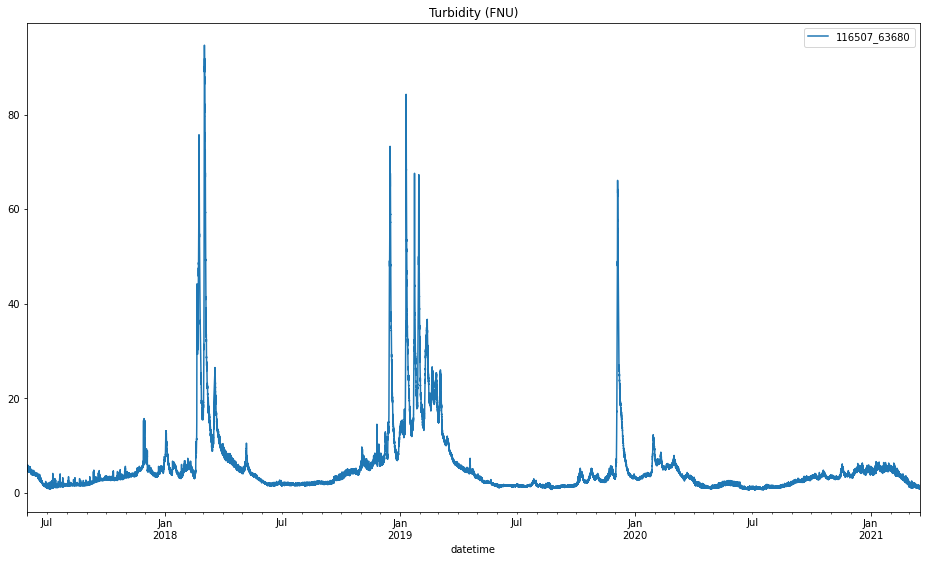

In [ ]:
df_turbidity[['116507_63680']].plot(title='Turbidity (FNU)',figsize=(16,9))

## Datasets Para Entrenamiento

Ees importante igualar el cjto de entrenamiento / test a a las proporciones 80/20%, si bien el mantenimiento de las geometrías representativas es también importante.


Cjto Entrenamiento % : 85.44672111105677
Cjto Test % : 14.55816910362365


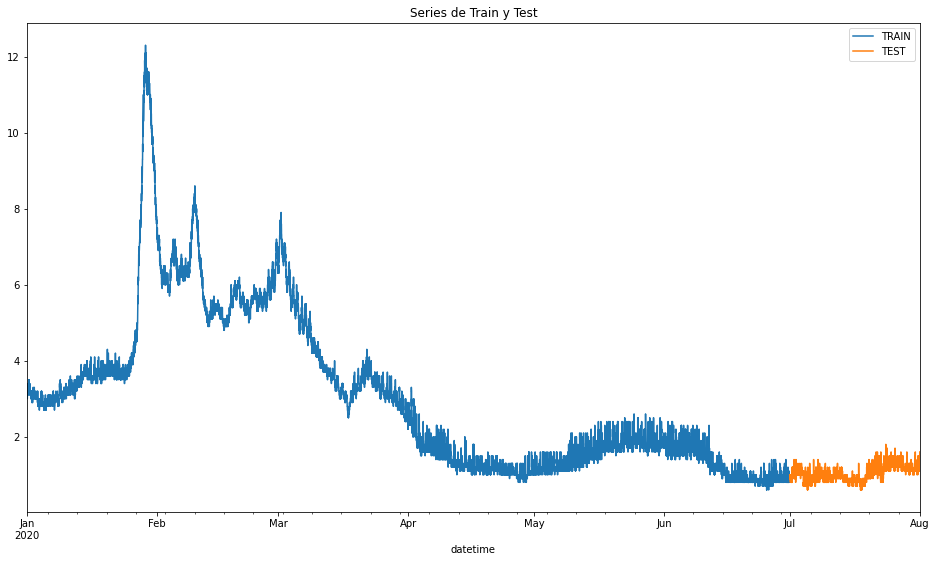

In [ ]:
# Split into train and test set

UpperBound = '2020-08-01 0:00:00'
LowerBound = '2020-01-01 0:00:00'
TestBound = '2020-07-01 0:00:00'



df_range = pd.DataFrame()
train_turbidity= pd.DataFrame()
test_turbidity= pd.DataFrame()

df_range['116507_63680']=df_turbidity['116507_63680'][LowerBound:UpperBound]

train_turbidity['116507_63680']=df_range['116507_63680'][:TestBound]
test_turbidity['116507_63680']=df_range['116507_63680'][TestBound:]

train_turbidity['116507_63680'].plot(legend=True,label='TRAIN',figsize=(16,9))
test_turbidity['116507_63680'].plot(legend=True,label='TEST',figsize=(16,9))

train_turbidity.index.freq="15T"
test_turbidity.index.freq="15T"

plt.title('Series de Train y Test')

print("Cjto Entrenamiento % :",(train_turbidity.shape[0]/df_range.shape[0])*100)
print("Cjto Test % :",(test_turbidity.shape[0]/df_range.shape[0])*100)

## Definiciones Generales de Modelos

Horizontes de Predicción: El dataset toma una muesta cada 15 minutos, por lo tanto 1H = 4 muestras, 3 H = 3*4=12 muestras ...

In [ ]:
forecast_steps_dict = {
  "1H": 4,
  "3H": 12,
  "6H": 24,
  "12H": 48,
  "1D": 96,
  "2D": 192,
  "5D": 480,
  "7D": 672,
  "15D": 1440
}

In [ ]:
    from keras.models import Sequential
    from keras.layers import Dense,Flatten
    from keras.layers.convolutional import Conv1D,MaxPooling1D
    from keras.optimizers import Adam
    from keras.losses import Huber

    import keras.callbacks

In [ ]:
from keras.layers import LSTM, Embedding, TimeDistributed,Bidirectional, Dense, InputLayer,Activation

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 3)

In [ ]:
def split_sequences(sequences, n_steps):
  from numpy import array
  
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences)-1:
      break

    # gather input and output parts of the pattern
        
    seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


In [ ]:
#Source: https://setscholars.net/time-series-forecasting-in-python-using-deep-learning-cnn-model-with-bj-sales-dataset-data-science/
   
   
# choose a number of time steps
n_steps = forecast_steps_dict["7D"]
# convert into input/output
X_train, y_train = split_sequences(train_turbidity['116507_63680'], n_steps)
X_test, y_test = split_sequences(test_turbidity['116507_63680'], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



In [ ]:
train_turbidity['116507_63680'].shape

(17473,)

In [ ]:
test_turbidity['116507_63680'].shape

(2977,)

In [ ]:
X_train.shape, y_train.shape  

((16801, 672, 1), (16801,))

## Modelo Convolutional MLP : 
Nótese que las capas convolucionales CNN han sido cambiadas por capas más modernas Conv1D

In [ ]:
model_cnn = Sequential(name="Convolutional_MLP")

In [ ]:
# define model - using CNN model

model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))    
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.summary()

In [ ]:
history = model_cnn.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test), callbacks = [early_stop])


In [ ]:
yhat = model_cnn.predict(X_test, verbose=1)
y_pred = yhat.squeeze().copy()
df_pred = pd.DataFrame.from_records(yhat, columns = ['predicted'])
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred['predicted'][0:n_steps]
df_pred.columns = ['predicted']  

df_actual = test_turbidity['116507_63680'][0:n_steps]
df_actual.columns =['actual'] 

df_actual = df_actual.reset_index(drop=True)

y_pred = df_pred.values
y_actual = df_actual.values

calculate_error(y_pred, y_actual)

## CNN + LSTM


In [ ]:
model_cnn_lstm = Sequential(name = "CNN_LSTM")

In [ ]:
model_cnn_lstm.add(Conv1D(filters=512, kernel_size=2, activation='relu',input_shape=(n_steps, n_features)))
model_cnn_lstm.add(LSTM(100, return_sequences=True))
model_cnn_lstm.add(LSTM(25, return_sequences=True))
model_cnn_lstm.add(TimeDistributed(Dense(1, activation= 'relu' )))
model_cnn_lstm.compile(loss=Huber() , optimizer='adam' , metrics=['acc'])
model_cnn_lstm.summary()

Model: "CNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 671, 512)          1536      
_________________________________________________________________
lstm (LSTM)                  (None, 671, 100)          245200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 671, 25)           12600     
_________________________________________________________________
time_distributed (TimeDistri (None, 671, 1)            26        
Total params: 259,362
Trainable params: 259,362
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_cnn_lstm.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test), callbacks = [early_stop])

In [ ]:
yhat = model_cnn_lstm.predict(X_test, verbose=1)
y_pred =yhat[672].squeeze()
df_pred = pd.DataFrame(data=y_pred, columns = ['predicted'])
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred['predicted'][0:n_steps]
df_pred.columns = ['predicted']  

df_actual = test_turbidity['116507_63680'][0:n_steps]
df_actual.columns =['actual'] 

df_actual = df_actual.reset_index(drop=True)

In [ ]:
y_pred = df_pred
y_actual = df_actual

calculate_error(y_pred, y_actual)

## Wavenet :


In [ ]:
model_wavenet = keras.models.Sequential(name="WaveNet")

In [ ]:
model_wavenet.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model_wavenet.add(keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model_wavenet.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model_wavenet.add(Dense(1, activation='relu'))   

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model_wavenet.compile(optimizer=optimizer,loss=Huber())



In [ ]:
model_wavenet.summary()

Model: "WaveNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           33  

In [ ]:
history = model_wavenet.fit(X_train, y_train, epochs=15,validation_data=(X_test, y_test), callbacks = [early_stop])

In [ ]:
yhat = model_wavenet.predict(X_test, verbose=1)
y_pred =yhat[672].squeeze()
df_pred = pd.DataFrame(data=y_pred, columns = ['predicted'])
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred['predicted'][0:n_steps]
df_pred.columns = ['predicted']  

df_actual = test_turbidity['116507_63680'][0:n_steps]
df_actual.columns =['actual'] 

df_actual = df_actual.reset_index(drop=True)

73/73 [==============================] - 3s 38ms/step


In [ ]:
y_pred = df_pred
y_actual = df_actual

calculate_error(y_pred, y_actual)

## Bidirectional LSTM

In [ ]:
model_bidirectional = Sequential(name = 'Bidirectional_LSTM')

In [ ]:
model_bidirectional.add(Bidirectional(LSTM(50, return_sequences=True),input_shape=(n_steps, n_features)))
model_bidirectional.add(Bidirectional(LSTM(25, return_sequences=True)))
model_bidirectional.add(TimeDistributed(Dense(1, activation= 'relu' )))
model_bidirectional.compile(loss=Huber() , optimizer='adam' , metrics=['acc'])
model_bidirectional.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 672, 100)          20800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 672, 50)           25200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 672, 1)            51        
Total params: 46,051
Trainable params: 46,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_bidirectional.fit(X_train, y_train, epochs=15, verbose=1)

In [ ]:
yhat = model_bidirectional.predict(X_test, verbose=1)
y_pred =yhat[672].squeeze()
df_pred = pd.DataFrame(data=y_pred, columns = ['predicted'])
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred['predicted'][0:n_steps]
df_pred.columns = ['predicted']  

df_actual = test_turbidity['116507_63680'][0:n_steps]
df_actual.columns =['actual'] 

df_actual = df_actual.reset_index(drop=True)

73/73 [==============================] - 4s 34ms/step


In [ ]:
y_pred = df_pred
y_actual = df_actual

calculate_error(y_pred, y_actual)